In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importação de Bibliotecas.

In [ ]:
from skimage.morphology import binary_erosion
from skimage.morphology import square
from skimage.morphology import remove_small_objects
from skimage.segmentation import watershed,clear_border
from skimage.feature import peak_local_max,canny
from skimage.measure import regionprops,label
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
import pandas as pd
import numpy as np
import cv2

# Leitura da Imagem Segmentada pelo Kmeans na Etapa 2

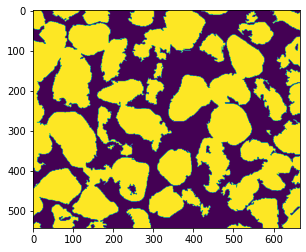

In [ ]:
input_image_path0 = '/content/drive/MyDrive/EXPA/ML-Segmentation/Etapa3/Sandstone-modelo-etapa3.jpg'
img = cv2.imread(input_image_path0,cv2.IMREAD_GRAYSCALE) 
img2 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
image=img2[1]
plt.imshow(image)
plt.show()

# Conversão do valor dos pixels da imagem

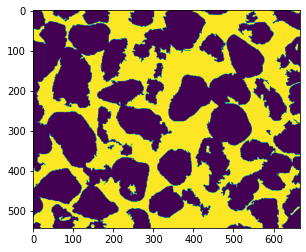

In [ ]:
image_copy=image.copy()
image[image==255]=150 
image[image==0]=255
image[image==150]=0
plt.imshow(image)
plt.show()

# Definição de Regiões da Imagem Com calculo de Parâmetros Morfologicos da Imagem.

In [ ]:
all_labels = label(image)

props = regionprops(all_labels)
entries = []
for p in props:
    entry = [p['label'], p['area'],p['coords']]
    entries.append(entry)
df0 = pd.DataFrame(entries, columns= ['label', 'area','coords'])
df0['area']

0    141473
1       134
2       738
3        80
4     11165
5       133
6       294
7       121
8       200
9        71
Name: area, dtype: int64

# Remoção de obtejos menores que uma área pré-definida.

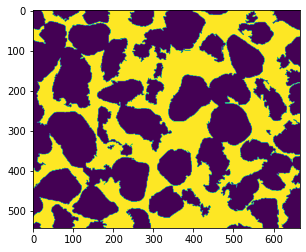

In [ ]:
df0 = df0[df0.area > 300]
df0=df0.reset_index()
lmt=0
image_fix=image.copy()
image_fix[image_fix>0]=0
while lmt < len(df0):
    for x in range(len(df0['coords'][lmt])):
        image_fix[df0['coords'][lmt][x][0],df0['coords'][lmt][x][1]]=255
    lmt+=1
plt.imshow(image_fix)
plt.show()

# Conversão pixels ao seu valor inicial

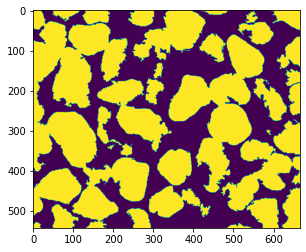

In [ ]:
image_fix[image_fix==255]=150 
image_fix[image_fix==0]=255
image_fix[image_fix==150]=0
plt.imshow(image_fix)
plt.show()

# Definição dos limites entre grãos utilizando o algoritimo watershed
> Watershed: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

> ndi.distance_transform_edt: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html

> peak_local_max: https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max

<ipython-input-9-29eadc07b2fa>:9: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel,kernel)),


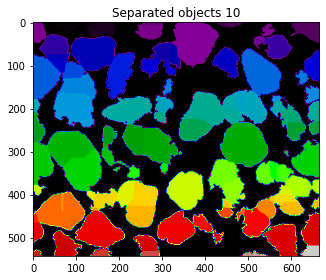

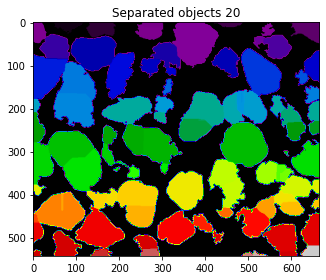

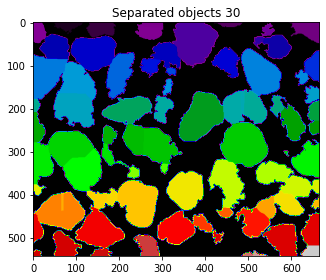

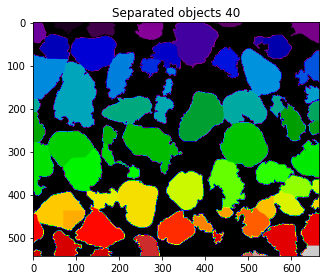

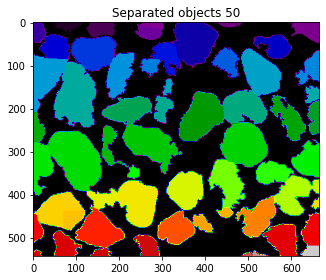

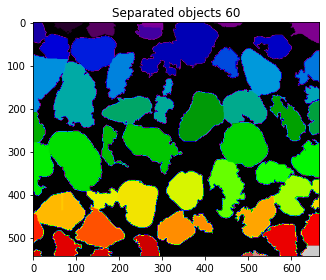

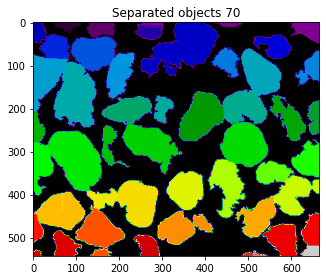

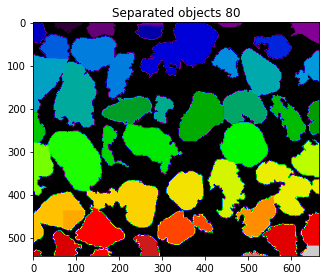

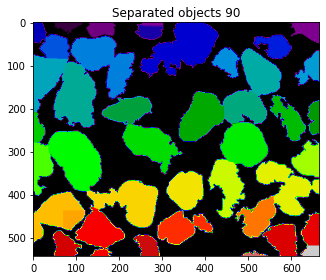

In [ ]:
for alpha in range(1,10):
  kernel = alpha*10
  dist = 'edt' #edt (transformada da distância euclidiana) ou cdt
  flagprint = 1
  if (dist == 'edt'):
    distance = ndi.distance_transform_edt(image_fix)
  else:
    distance = ndi.distance_transform_cdt(image_fix) 
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel,kernel)),
                          labels=image_fix)
  distance = ndi.distance_transform_edt(image_fix)
  markers = ndi.label(local_maxi)[0]
  labels = watershed(-distance, markers, mask=image_fix)
  if (flagprint == 1):
    plt.imshow(labels, cmap=plt.cm.nipy_spectral)
    plt.title('Separated objects '+ str(kernel))
    plt.tight_layout()
    plt.show()

# Escolha do melhor parametro aplicado no Watershed e exclusão dos grãos da borda.

<ipython-input-10-17c6d076e383>:8: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel,kernel)),


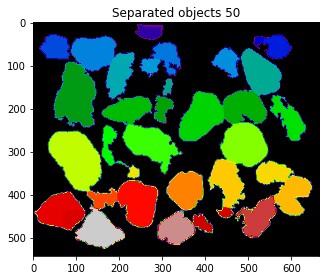

In [ ]:
  kernel = 50
  dist = 'edt' #edt (transformada da distância euclidiana) ou cdt
  flagprint = 1
  if (dist == 'edt'):
    distance = ndi.distance_transform_edt(image_fix)
  else:
    distance = ndi.distance_transform_cdt(image_fix) 
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel,kernel)),
                          labels=image_fix)
  distance = ndi.distance_transform_edt(image_fix)
  markers = ndi.label(local_maxi)[0]
  labels = watershed(-distance, markers, mask=image_fix)
  labels=clear_border(labels)
  if (flagprint == 1):
    plt.imshow(labels, cmap=plt.cm.nipy_spectral)
    plt.title('Separated objects '+ str(kernel))
    plt.tight_layout()
    plt.show()

# Obtenção de atributos dos grãos identificados na imagem.

In [ ]:
props = regionprops(labels)
entries = []
for p in props:
    entry = [p['label'], p['area'], p['perimeter'],p['MajorAxisLength'],p['MinorAxisLength'],p['centroid'],p['coords'],p['orientation']]
    entries.append(entry)
    
df2 = pd.DataFrame(entries, columns= ['label', 'area','perimeter','MajorAxisLength','MinorrAxisLength','centroid','coords','orientation'])
pixel_to_mm = 0.00294
df2['area']=df2['area']*(pixel_to_mm**2)
df2['perimeter']=df2['perimeter']*pixel_to_mm
df2['MajorAxisLength (mm)']=df2['MajorAxisLength']*pixel_to_mm
df2['MinorrAxisLength (mm)']=df2['MinorrAxisLength']*pixel_to_mm
df2['GrainSize(mm)']=(df2['MajorAxisLength (mm)'])
df2['roundness']=(df2['perimeter']*df2['perimeter'])/df2['area']
df2=df2[['area','perimeter','GrainSize(mm)','roundness','orientation','centroid','coords']]

df2

,area,perimeter,GrainSize(mm),roundness,orientation,centroid,coords
0,0.002204,0.316720,0.164621,45.511001,1.494404,"(9.980392156862745, 280.3058823529412)","[[7, 254], [7, 255], [7, 256], [7, 257], [7, 2..."
1,0.012697,0.544476,0.186452,23.347545,1.442066,"(23.88291354663036, 269.0068073519401)","[[5, 242], [5, 243], [6, 242], [6, 243], [6, 2..."
2,0.003319,0.263523,0.080225,20.922309,-0.653422,"(43.1875, 522.9453125)","[[33, 521], [33, 522], [33, 523], [33, 524], [..."
3,0.022568,0.678830,0.185111,20.418324,1.037673,"(56.79279969360398, 566.6698582918422)","[[30, 561], [30, 562], [30, 563], [30, 564], [..."
4,0.026631,0.664930,0.200576,16.602173,1.275744,"(58.53034728984096, 52.31515741642324)","[[28, 41], [28, 42], [28, 43], [28, 44], [28, ..."
5,0.026199,1.020219,0.241851,39.728864,0.567261,"(79.08940943582977, 311.65291982843945)","[[46, 316], [46, 317], [47, 308], [47, 309], [..."
6,0.055838,0.950772,0.311625,16.189216,-1.523686,"(69.6907120743034, 141.10913312693498)","[[32, 167], [32, 168], [32, 169], [33, 159], [..."
7,0.023528,0.861250,0.207483,31.526494,0.587745,"(91.82880235121235, 450.36039676708305)","[[58, 447], [58, 448], [59, 444], [59, 445], [..."
8,0.011410,0.537483,0.134003,25.319817,-1.397880,"(101.23257575757576, 271.4840909090909)","[[84, 256], [84, 257], [84, 258], [84, 268], [..."
9,0.040296,1.067486,0.335749,28.278559,-0.334299,"(119.55276705276705, 200.26426426426426)","[[70, 228], [70, 229], [70, 230], [70, 231], [..."
